In [1]:
import os
import os.path
import numpy as np
import glob
import matplotlib.pyplot as plt
import preprocessing_functions as pre
import training_functions as training


Using TensorFlow backend.


In [13]:
# normalize all images
images = glob.glob(r"C:\Users\tsche\Desktop\Master\2. Semester\Project Staining\16bitImages\*d0.png") # define imagefolder
(X_images, mean_norm, std_norm) = pre.norm_and_stack(images)
images = glob.glob(r"C:\Users\tsche\Desktop\Master\2. Semester\Project Staining\16bitImages\*d1.png") # define imagefolder
Y_images= pre.norm(images, mean_norm, std_norm)

In [14]:
# define images for training (change to automated later)
X_train = X_images[:,:,0:130]
Y_train = Y_images[:,:,0:130]
X_val = X_images[:,:,130:157]
Y_val = Y_images[:,:,130:157]

In [4]:
X_train.shape

(1104, 1104, 130)

In [5]:
# train UNet
history = training.train(X_train, Y_train, X_val, Y_val)



Input (None, 128, 128, 1)
1. Conv (None, 64, 64, 64)
2. conv (None, 64, 64, 128)
3. conv (None, 32, 32, 256)
4. conv (None, 16, 16, 512)
1. UpConv (None, 32, 32, 768)
2. UpConv (None, 64, 64, 384)
3. UpConv (None, 128, 128, 192)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
______________________________________________________________

10/10 [==============================] - 52s 5s/step - loss: 1.1125 - mse: 1.1125 - mae: 0.7862 - val_loss: 0.2129 - val_mse: 0.2129 - val_mae: 0.3875
Epoch 2/15
10/10 [==============================] - 47s 5s/step - loss: 0.4623 - mse: 0.4623 - mae: 0.5592 - val_loss: 0.2280 - val_mse: 0.2280 - val_mae: 0.3717
Epoch 3/15
10/10 [==============================] - 48s 5s/step - loss: 0.3806 - mse: 0.3806 - mae: 0.4711 - val_loss: 0.7351 - val_mse: 0.7351 - val_mae: 0.5177
Epoch 4/15
10/10 [==============================] - 48s 5s/step - loss: 0.3233 - mse: 0.3233 - mae: 0.4491 - val_loss: 0.2986 - val_mse: 0.2986 - val_mae: 0.4748
Epoch 5/15
10/10 [==============================] - 50s 5s/step - loss: 0.2623 - mse: 0.2623 - mae: 0.4163 - val_loss: 0.2032 - val_mse: 0.2032 - val_mae: 0.4067
Epoch 6/15
10/10 [==============================] - 49s 5s/step - loss: 0.5069 - mse: 0.5069 - mae: 0.4508 - val_loss: 0.2477 - val_mse: 0.2477 - val_mae: 0.4190
Epoch 7/15
10/10 [=====================

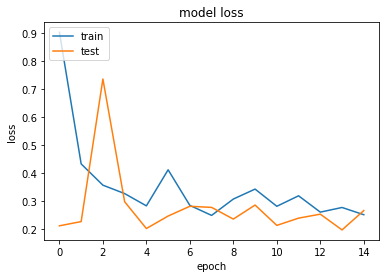

In [6]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
output.shape

(1104, 1104, 1)

In [20]:
import prediction as pred
import keras
out = []
model = keras.models.load_model(r"..\models\test_model")
for n in range(5):
    image = X_val[:,:,3*n]

    output = pred.predict(model, image, 128, 128, num_outputs=1)
    output_norm = pre.unnormalize(output, mean_norm, std_norm)
    out.append(output_norm)
out = np.stack(out, axis = 0)

(144, 128, 128, 1)


In [8]:
out.shape

(5, 1104, 1104, 1)

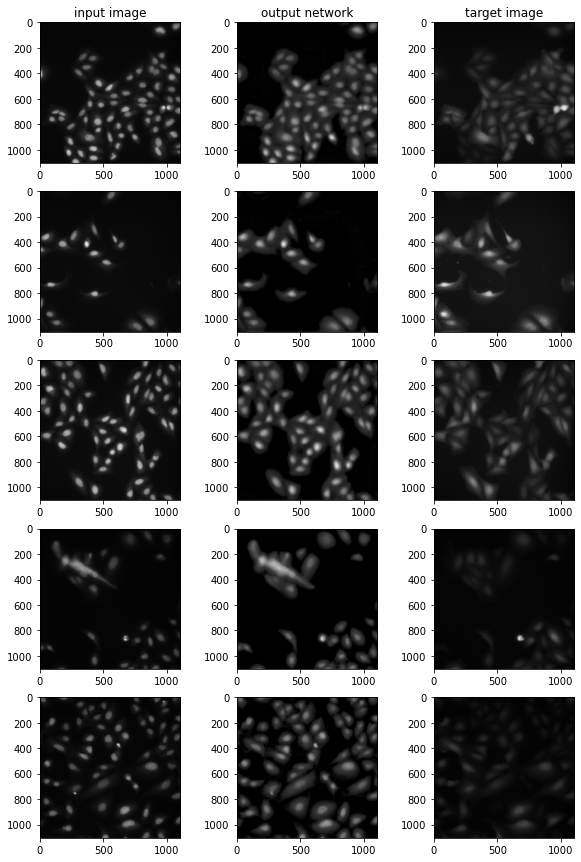

In [15]:
plt.figure(figsize=(10,15)) 

for p in range(5):
    plt.subplot(5,3,1+3*p)    
    plt.imshow(X_val[:,:,3*p], cmap='gray')
    if p == 0:
        plt.title('input image')

    plt.subplot(5,3,2+3*p)    
    plt.imshow(out[p], cmap='gray')
    if p == 0:
        plt.title('output network')

    plt.subplot(5,3,3+3*p) 
    plt.imshow(Y_val[:,:,3*p], cmap='gray')
    if p == 0:
        plt.title('target image')

plt.show()

